In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install statsmodels

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install tabulate

In [ ]:
pip install PrettyTable

In [42]:
pip install propensity

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement propensity (from versions: none)
ERROR: No matching distribution found for propensity


## Code Begins here

In [1]:
import json
import os
import csv
import collections
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import shutil
import time
from scipy.stats import zscore
from scipy import stats
from sklearn import preprocessing
from sklearn import utils
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

import io
import requests
from sklearn import metrics
from keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
import lightgbm as lgb

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, r2_score, roc_curve, auc


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32, np.object):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
df =pd.read_csv('C:/Users/HamzaPC/Desktop/Seminar/fifa.csv')
df_18 =pd.read_csv('C:/Users/HamzaPC/Desktop/Seminar/players_18.csv')


# Function to convert string values to numeric
import numpy as np

def convert_to_numeric(value):
    if pd.isna(value) or value == '':
        return 0
    elif isinstance(value, (int, float)):
        return float(value)
    elif 'M' in value:
        return float(value.replace('€', '').replace('M', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('€', '').replace('K', '')) * 1e3
    else:
        return np.nan


# Apply the function to the 'Values' column
df['Value'] = df['Value'].apply(convert_to_numeric)
df['Wage'] = df['Wage'].apply(convert_to_numeric)

df.drop(['Photo','Flag','Potential','Club Logo','Special','International Reputation','Weak Foot','Real Face','Jersey Number','Joined','Loaned From'
        ,'Contract Valid Until','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM'
         ,'CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Release Clause','Work Rate'],axis=1,inplace=True)



df['Position'].fillna('ST', inplace = True)
df['Weight'].fillna('200lbs', inplace = True)
df['Height'].fillna("5'11", inplace = True)
df['Nationality'].fillna('Pakistani', inplace = True)
df['Body Type'].fillna('Normal', inplace = True)
df['Skill Moves'].fillna(df['Skill Moves'].median(), inplace = True)
df['Preferred Foot'].fillna('Right', inplace = True)

df.dropna(inplace = True)
df_18 = df_18[df_18['wage_eur'] != 0]

df = df[df['ID'].isin(df_18['sofifa_id'])]
df_18 = df_18[df_18['sofifa_id'].isin(df['ID'])]


df_DRLR = df.copy()
df_LR = df.copy()
df_LR_IG = df.copy()
df_DRRF = df.copy()
df_Naive = df.copy()
df_Test = df.copy()

C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Assuming df is your DataFrame
wage_empty_count = df_18['wage_eur'].isna().sum()

# # Display the count of empty values in the 'Wage' column
# print("Number of empty values in 'Wage':", wage_empty_count)

print("Number of rows in df_18:", len(df_18))
print("Number of rows in df:", len(df))

Number of rows in df_18: 12097
Number of rows in df: 12097


In [3]:
sofifa_id_to_wage_eur = df_18.set_index('sofifa_id')['wage_eur'].to_dict()


sofifa_id_to_overall = df_18.set_index('sofifa_id')['overall'].to_dict()

# Add a new column "TreatedWage" to df based on the subtraction of Wage and wage_eur
df['TreatedWage'] = df['ID'].map(sofifa_id_to_wage_eur).sub(df['Wage'])

df['TreatedOverall'] = df['ID'].map(sofifa_id_to_overall).sub(df['Overall'])

print(df[['Name','Wage','TreatedWage','Overall','TreatedOverall']])

                    Name      Wage  TreatedWage  Overall  TreatedOverall
0               L. Messi  565000.0          0.0       94              -1
1      Cristiano Ronaldo  405000.0     160000.0       94               0
2              Neymar Jr  290000.0     -10000.0       92               0
3                 De Gea  260000.0     -45000.0       91              -1
4           K. De Bruyne  355000.0     -70000.0       91              -2
...                  ...       ...          ...      ...             ...
18177          R. Roache    1000.0          0.0       48               0
18180           M. Hurst    1000.0          0.0       48               0
18196        K. Fujikawa    1000.0          0.0       47               0
18200           J. Young    1000.0          0.0       47              -1
18202       J. Lundstram    1000.0          0.0       47              -1

[12097 rows x 5 columns]


In [4]:
# Create FinalTreatment column
df['FinalTreatment'] = 0  # Initialize with 0

# Update FinalTreatment based on conditions
mask = (df['TreatedWage'] != 0) & (df['TreatedOverall'] != 0)
df.loc[mask, 'FinalTreatment'] = 1

In [5]:
print(df[['Name','TreatedWage','Overall','TreatedOverall','FinalTreatment']])

                    Name  TreatedWage  Overall  TreatedOverall  FinalTreatment
0               L. Messi          0.0       94              -1               0
1      Cristiano Ronaldo     160000.0       94               0               0
2              Neymar Jr     -10000.0       92               0               0
3                 De Gea     -45000.0       91              -1               1
4           K. De Bruyne     -70000.0       91              -2               1
...                  ...          ...      ...             ...             ...
18177          R. Roache          0.0       48               0               0
18180           M. Hurst          0.0       48               0               0
18196        K. Fujikawa          0.0       47               0               0
18200           J. Young          0.0       47              -1               0
18202       J. Lundstram          0.0       47              -1               0

[12097 rows x 5 columns]


In [6]:

df_DRLR = df.copy()
df_LR = df.copy()
df_LR_IG = df.copy()
df_DRRF = df.copy()
df_Naive = df.copy()
df_Test = df.copy()

In [7]:


col = ['Name', 'Age', 'Nationality', 'Value', 'Wage', 'Preferred Foot', 'Skill Moves', 'Body Type', 'Position', 'Height', 
       'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
column_types = df_Test[col].dtypes


col = ['Age', 'Value', 'Wage', 'Skill Moves',   
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
for x in col:
    encode_numeric_range(df_Test,x)


encode_text_index(df_Test,'Preferred Foot')
encode_text_index(df_Test,'Body Type')
encode_text_index(df_Test,'Nationality')
encode_text_index(df_Test,'Height')
encode_text_index(df_Test,'Weight')
encode_text_index(df_Test,'Position')
df_Test.dropna(inplace = True)


col_Test = ['Age', 'Value', 'Wage', 'Skill Moves',   
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


for x_Test in col_Test:
    remove_outliers(df_Test,x_Test,3)

df_x_Test = df_Test[['Age', 'Value', 'Wage', 'Skill Moves',   
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']].copy()
df_y_Test = df_Test['Overall'].copy()


## end here

# Chi-Square to check important columns

In [8]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_best = SelectKBest(chi2, k=30)
X_ch2 = chi2_best.fit_transform(df_x_Test, df_y_Test)
selected_feature_indices = chi2_best.get_support(indices=True)
selected_features = df_x_Test.columns[selected_feature_indices]

print('\n\n\nThe best features of the chi2 test are:')
for i, feature in enumerate(reversed(selected_features), 1):
    print('{}. {}'.format(i, feature))




The best features of the chi2 test are:
1. SlidingTackle
2. StandingTackle
3. Marking
4. Composure
5. Penalties
6. Vision
7. Positioning
8. Interceptions
9. Aggression
10. LongShots
11. Strength
12. Stamina
13. Jumping
14. ShotPower
15. Reactions
16. Agility
17. BallControl
18. LongPassing
19. FKAccuracy
20. Curve
21. Dribbling
22. Volleys
23. ShortPassing
24. HeadingAccuracy
25. Finishing
26. Crossing
27. Skill Moves
28. Wage
29. Value
30. Age


# Linear Regression 

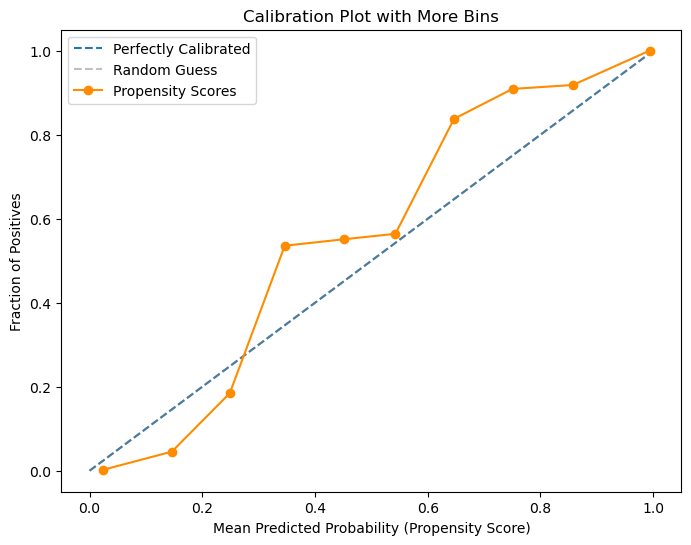

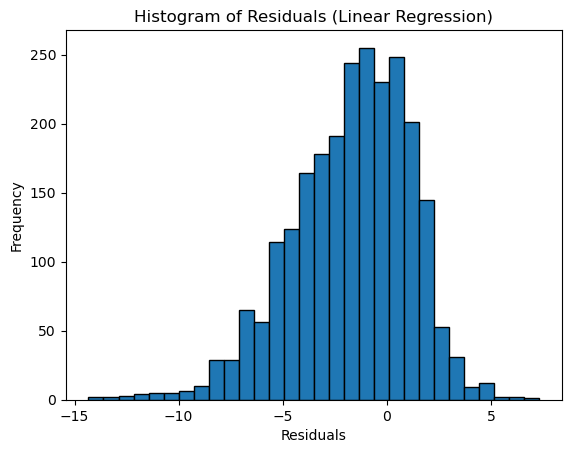

In [9]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd

# Select relevant columns for logistic regression modeling
logistic_cols = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 
                 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 
                 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 
                 'Skill Moves', 'Value', 'Age', 'Overall','Wage']

# Create the feature matrix X and target variable y for logistic regression modeling
X_logistic = df_LR[logistic_cols].dropna().drop('Overall', axis=1)
y_logistic = (df_LR['Overall'] > df_LR['Overall'].median()).astype(int)

# Fit a Logistic Regression model for propensity modeling
logistic_model = LogisticRegression()
logistic_model.fit(X_logistic, y_logistic)

# Obtain predicted probabilities for each observation
df_LR['PropensityScore'] = logistic_model.predict_proba(X_logistic)[:, 1]

# Select relevant columns for linear regression modeling
cols_for_modeling = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 
                 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 
                 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 
                 'Skill Moves', 'Value', 'Age', 'Overall','Wage']

# Create feature matrix X and target variable y for linear regression modeling
X = df_LR[cols_for_modeling].dropna().drop('Overall', axis=1)
y = df_LR['Overall'].dropna()

# Split the data into training and testing sets for linear regression modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a new column indicating treatment status

# Assuming 'PropensityScore' is a column in your DataFrame containing propensity scores
# Use this column as a weight for linear regression
weights = df_LR['PropensityScore']

# Standardize numerical variables in X_train and X_test
scaler_lr = StandardScaler()
X_train_std = scaler_lr.fit_transform(X_train)
X_test_std = scaler_lr.transform(X_test)

# Fit a weighted linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_std, y_train, sample_weight=weights[X_train.index])

# Predict the outcome on the standardized test set
y_pred = lr_model.predict(X_test_std)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate ATT using stratification
# att_by_quintile = df_LR.groupby('Treated')['Overall'].mean().diff().iloc[1]
# Calculate ATT using a different approach
att_by_quintile = df_LR.loc[df_LR['FinalTreatment'] == 1, 'Overall'].mean() - df_LR.loc[df_LR['FinalTreatment'] == 0, 'Overall'].mean()


# Calculate Accuracy (optional)
accuracy_linear = accuracy_score(y_test, y_pred.round())


variables = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 
             'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 
             'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 
             'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age','Wage']

# Create an empty dictionary to store results
standardized_biases = {}

def calculate_standardized_bias(df, covariate, treatment_column, propensity_score_column):
    treated_group = df[df[treatment_column] == 1]
    control_group = df[df[treatment_column] == 0]

    mean_treated = treated_group[covariate].mean()
    mean_control = control_group[covariate].mean()

    std_treated = treated_group[covariate].std()
    std_control = control_group[covariate].std()

    propensity_weighted_mean_treated = (treated_group[covariate] * treated_group[propensity_score_column]).sum() / treated_group[propensity_score_column].sum()
    propensity_weighted_mean_control = (control_group[covariate] * control_group[propensity_score_column]).sum() / control_group[propensity_score_column].sum()

    standardized_bias = (propensity_weighted_mean_treated - propensity_weighted_mean_control) / ((std_treated + std_control) / 2)

    return standardized_bias


# Loop through each variable
for variable in variables:
    # Calculate Standardized Bias for the current variable
    standardized_bias = calculate_standardized_bias(df_LR, variable, 'FinalTreatment', 'PropensityScore')
    
    # Store the result in the dictionary
    standardized_biases[variable] = round(standardized_bias, 5)  


# Select relevant columns for propensity modeling
propensity_cols = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 
             'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 
             'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 
             'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age','Overall','Wage']

# Create the feature matrix X and target variable y for propensity modeling
X_propensity = df_LR[propensity_cols].dropna().drop('Overall', axis=1)
y_propensity = (df_LR['Overall'] > df_LR['Overall'].median()).astype(int)

# Standardize numerical variables (optional but can be beneficial)
scaler = StandardScaler()
X_propensity[['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 
             'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 
             'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 
             'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age','Wage']] = scaler.fit_transform(X_propensity[['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 
             'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 
             'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 
             'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age','Wage']])

# Split the data into training and testing sets for propensity modeling
X_train_propensity, X_test_propensity, y_train_propensity, y_test_propensity = train_test_split(
    X_propensity, y_propensity, test_size=0.2, random_state=1
)


propensity_model = LogisticRegression()
propensity_model.fit(X_train_propensity, y_train_propensity)

# Obtain predicted probabilities for each observation in the test set
y_pred_propensity = propensity_model.predict_proba(X_test_propensity)[:, 1]

# Calibration Plot with More Bins
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test_propensity, y_pred_propensity, n_bins=10, strategy='uniform')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5, label='Random Guess')
plt.plot(prob_pred, prob_true, marker='o', label='Propensity Scores', color='darkorange')
plt.xlabel('Mean Predicted Probability (Propensity Score)')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot with More Bins')
plt.legend(loc='upper left')
plt.show()


import matplotlib.pyplot as plt

# Assuming y_test_dr_rf is your actual values and y_pred_lr is your predicted values from Linear Regression
residuals_lr = y_test - y_pred

plt.hist(residuals_lr, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Regression)')
plt.show()


from tabulate import tabulate

# Summary Report Data
summary_data = [
    ["RMSE", rmse],
    ["R-squared", r_squared],
    ["ATT", att_by_quintile],
    ["Accuracy", accuracy_linear],
]

# Print the results
# for variable, bias in standardized_biases.items():
#     summary_data.append([f"Standardized Bias for {variable}", bias])
    


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


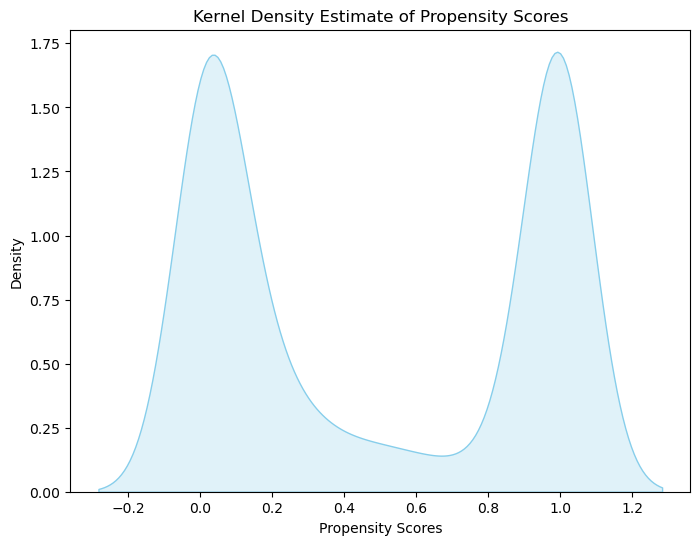

In [38]:
import seaborn as sns

# Plot kernel density estimate of propensity scores
plt.figure(figsize=(8, 6))
sns.kdeplot(y_pred_propensity, fill=True, color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Propensity Scores')
plt.show()


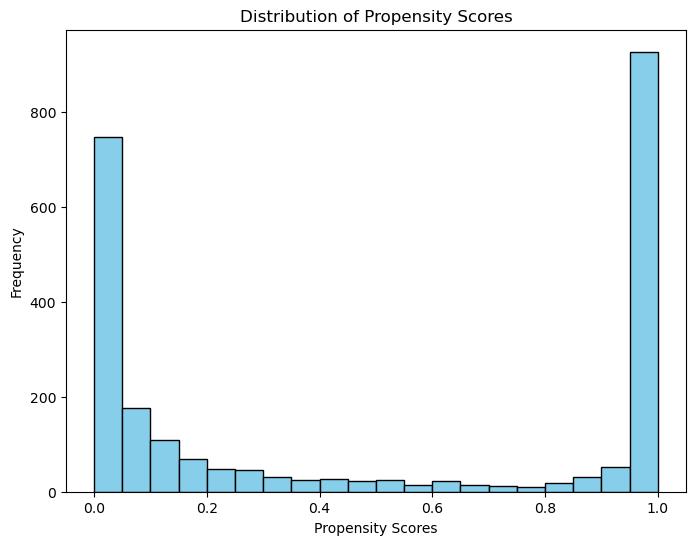

In [39]:
import matplotlib.pyplot as plt

# Plot histogram of propensity scores
plt.figure(figsize=(8, 6))
plt.hist(y_pred_propensity, bins=20, edgecolor='black', color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.show()


In [10]:
# Create and print the table
table = tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid")
print(table)


+-----------+----------+
| Metric    |    Value |
+===========+==========+
| RMSE      | 3.34551  |
+-----------+----------+
| R-squared | 0.715343 |
+-----------+----------+
| ATT       | 3.97966  |
+-----------+----------+
| Accuracy  | 0.134711 |
+-----------+----------+


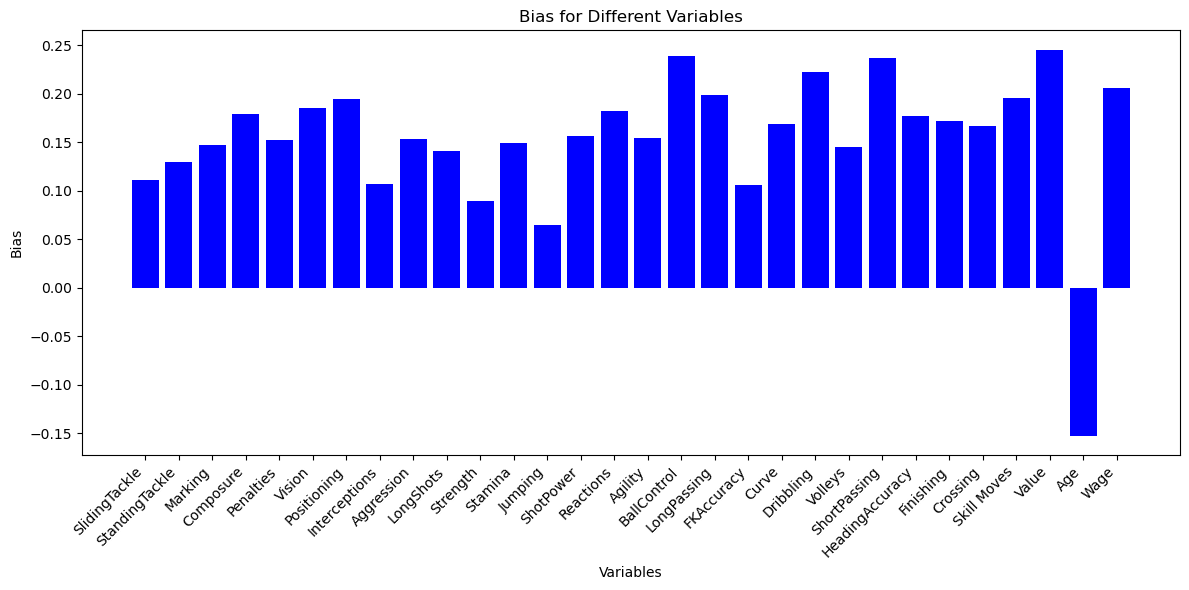

In [11]:
import matplotlib.pyplot as plt


# Extract variable names and biases
variables = list(standardized_biases.keys())
biases = list(standardized_biases.values())

# Create a bar plot with rotated x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(variables, biases, color='blue')
plt.xlabel('Variables')
plt.ylabel('Bias')
plt.title('Bias for Different Variables')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


# Doubly Robust Logistic Regression

In [12]:
#Doubly Robust (DR) with Logistic Regression (LR)

+------------------------------+---------+
| Metric                       |   Value |
+------------------------------+---------+
| Accuracy of Propensity Model | 0.59669 |
| ATT for DRLR                 | 3.97966 |
| RMSE                         |  0.6284 |
| R-squared                    | 0.98996 |
| AUC-ROC Score                | 0.70072 |
| F1 Score                     | 0.74741 |
+------------------------------+---------+


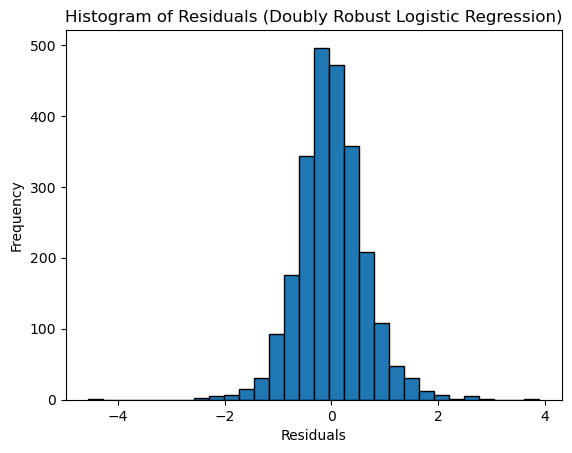

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor


# Select relevant columns for DR modeling
dr_cols = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 
                 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 
                 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 
                 'Skill Moves', 'Value', 'Age', 'Overall','Wage']

# Create the feature matrix X and target variable y
X_dr = df_DRLR[dr_cols].dropna().drop('Overall', axis=1)
y_dr = df_DRLR['Overall']
treat_dr = df_DRLR['FinalTreatment']

# Split the data into training and testing sets
X_train_dr, X_test_dr, y_train_dr, y_test_dr, treat_train_dr, treat_test_dr = train_test_split(
    X_dr, y_dr, treat_dr, test_size=0.2, random_state=1
)

# Fit logistic regression for treatment propensity
propensity_model_dr = LogisticRegression()
propensity_model_dr.fit(X_train_dr, treat_train_dr)

# Predict treatment probabilities on the test set
propensity_scores_dr = propensity_model_dr.predict_proba(X_test_dr)[:, 1]

# Standardize numerical variables (optional but can be beneficial)
scaler_dr = StandardScaler()
X_train_std_dr = scaler_dr.fit_transform(X_train_dr)
X_test_std_dr = scaler_dr.transform(X_test_dr)

# Fit outcome regression model (can be any model suitable for your data)
outcome_model_dr = GradientBoostingRegressor()
outcome_model_dr.fit(X_train_std_dr, y_train_dr)

# Predict the potential outcomes under treatment and control
y_treated_dr = outcome_model_dr.predict(X_test_std_dr)
y_control_dr = outcome_model_dr.predict(X_test_std_dr)

# Add the 'Treated' column to df_DRLR
df_DRLR.loc[X_test_dr.index, 'FinalTreatment'] = treat_test_dr.values


# Calculate the doubly robust treatment effect estimate
dr_estimate = np.mean(treat_test_dr * (y_test_dr - y_treated_dr) / propensity_scores_dr +
                      (1 - treat_test_dr) * (y_treated_dr - y_test_dr) / (1 - propensity_scores_dr))

# Print the Doubly Robust treatment effect estimate
#print(f"Doubly Robust Treatment Effect Estimate: {dr_estimate}")

# Check for accuracy (optional)
treat_pred_dr = propensity_scores_dr > 0.1  # Adjust threshold as needed
accuracy_dr = accuracy_score(treat_test_dr, treat_pred_dr)
#print(f"Accuracy of Propensity Model: {accuracy_dr}")

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated = df_DRLR[df_DRLR['FinalTreatment'] == 1]['Overall'].mean()
mean_outcome_untreated = df_DRLR[df_DRLR['FinalTreatment'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRLR = mean_outcome_treated - mean_outcome_untreated
#print('Average Treatment Effect on the Treated (ATT) for DRLR:', ATT_DRLR)

# Calculate RMSE
rmse = mean_squared_error(y_test_dr, y_treated_dr, squared=False)
#print('RMSE:', rmse)

# Calculate R-squared
r_squared = r2_score(y_test_dr, y_treated_dr)
# print('R-squared:', r_squared)

# Calculate AUC-ROC Score
auc_roc = roc_auc_score(treat_test_dr, propensity_scores_dr)
# print('AUC-ROC Score:', auc_roc)

# Check for accuracy (optional)
treat_pred_dr = propensity_scores_dr > 0.5  # Adjust threshold as needed
accuracy_dr = accuracy_score(treat_test_dr, treat_pred_dr)
#print(f"Accuracy of Propensity Model: {accuracy_dr}")

# Calculate F1 Score
f1 = f1_score(treat_test_dr, treat_pred_dr)
# print('F1 Score:', f1)

columns_of_interest = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 'Aggression', 
                       'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 
                       'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Wage', 'Value', 
                       'Age','Wage']

# Create an empty dictionary to store results
standardized_biases = {}

# Loop through each column of interest
for column in columns_of_interest:
    # Calculate mean and standard deviation for treated and untreated groups
    mean_treated = df_DRLR[df_DRLR['FinalTreatment'] == 1][column].mean()
    mean_untreated = df_DRLR[df_DRLR['FinalTreatment'] == 0][column].mean()

    std_treated = df_DRLR[df_DRLR['FinalTreatment'] == 1][column].std()
    std_untreated = df_DRLR[df_DRLR['FinalTreatment'] == 0][column].std()

    # Calculate Standardized Bias for the current column
    standardized_bias = (mean_treated - mean_untreated) / np.sqrt((std_treated**2 + std_untreated**2) / 2)
    
    # Store the result in the dictionary 
    standardized_biases[column] =  round(standardized_bias, 5) 



from prettytable import PrettyTable

# Summary Report Data
# round(f1, 5)],
summary_data = [
    # ["Doubly Robust Treatment Effect Estimate", round(dr_estimate, 5)],
    ["Accuracy of Propensity Model", round(accuracy_dr, 5)],
    ["ATT for DRLR", round(ATT_DRLR, 5)],
    ["RMSE", round(rmse, 5)],
    ["R-squared", round(r_squared, 5)],
    ["AUC-ROC Score",round(auc_roc, 5)],
    ["F1 Score", round(f1, 5)],
]

# for variable, bias in standardized_biases.items():
#     summary_data.append([f"Standardized Bias for {variable}", bias])

# Create the table
table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Add data to the table
for row in summary_data:
    table.add_row(row)

# Set the alignment of the columns
table.align["Metric"] = "l"
table.align["Value"] = "r"

# Print the table
print(table)




import matplotlib.pyplot as plt

# Assuming y_test_dr_rf is your actual values and y_pred_lr is your predicted values from Linear Regression
residuals_lr = y_test_dr - y_treated_dr

plt.hist(residuals_lr, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Doubly Robust Logistic Regression)')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


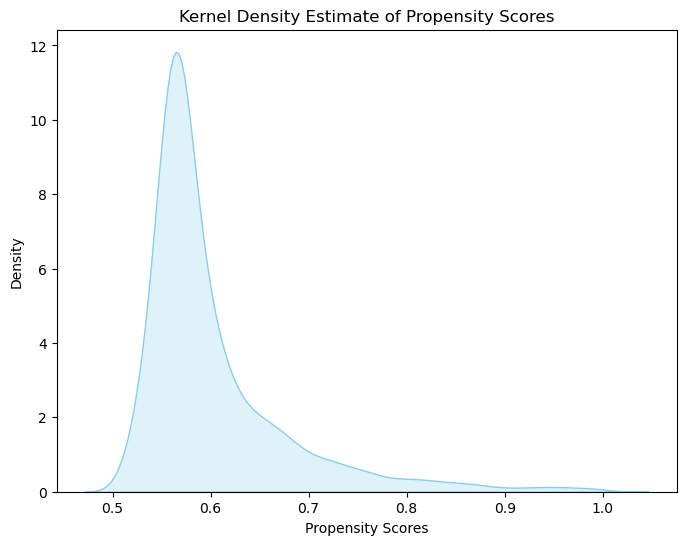

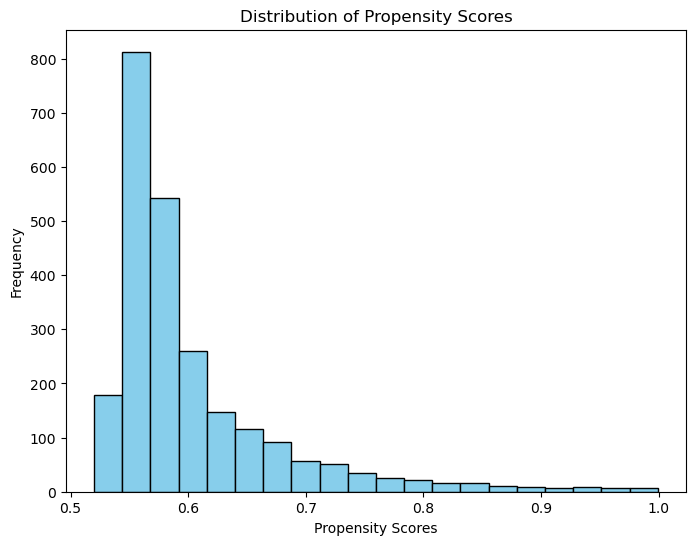

In [47]:
import seaborn as sns

# Plot kernel density estimate of propensity scores
plt.figure(figsize=(8, 6))
sns.kdeplot(propensity_scores_dr, fill=True, color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Propensity Scores')
plt.show()


import matplotlib.pyplot as plt

# Plot histogram of propensity scores
plt.figure(figsize=(8, 6))
plt.hist(propensity_scores_dr, bins=20, edgecolor='black', color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.show()


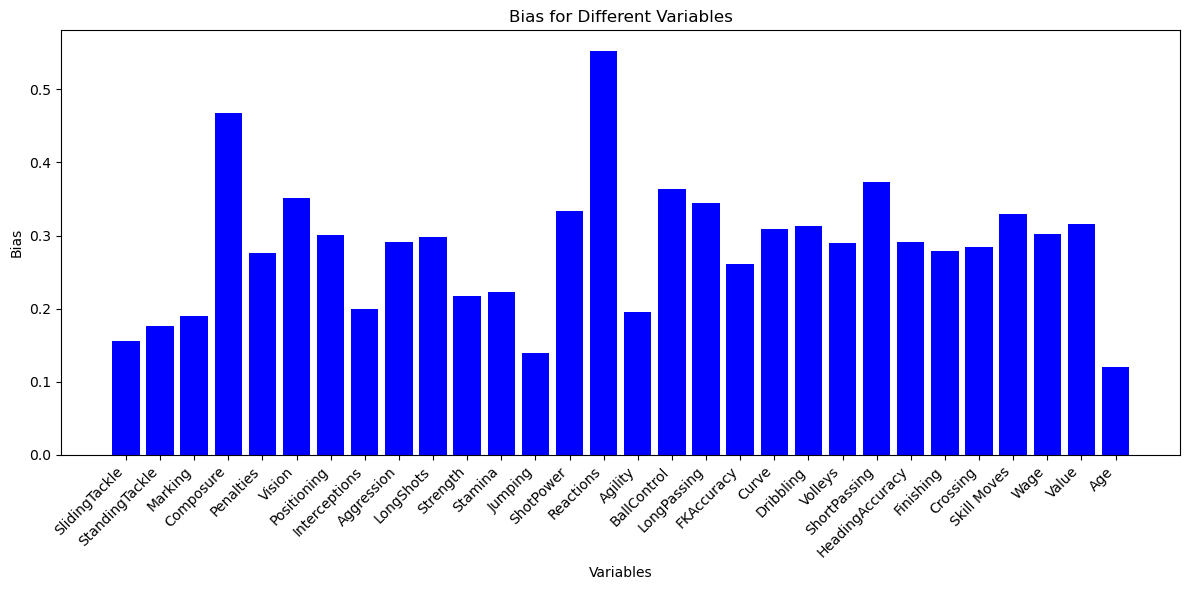

In [14]:
import matplotlib.pyplot as plt


# Extract variable names and biases
variables = list(standardized_biases.keys())
biases = list(standardized_biases.values())

# Create a bar plot with rotated x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(variables, biases, color='blue')
plt.xlabel('Variables')
plt.ylabel('Bias')
plt.title('Bias for Different Variables')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


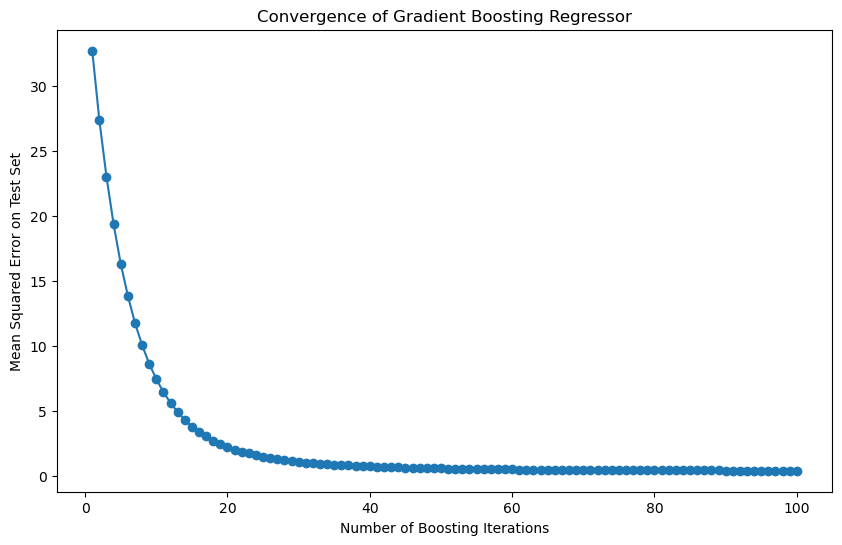

In [15]:
import matplotlib.pyplot as plt

# Fit outcome regression model (can be any model suitable for your data)
outcome_model_dr = GradientBoostingRegressor(n_estimators=100, random_state=1)
outcome_model_dr.fit(X_train_std_dr, y_train_dr)

# Access the staged predictions on the test set for each boosting iteration
staged_predictions = list(outcome_model_dr.staged_predict(X_test_std_dr))

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(staged_predictions) + 1), [mean_squared_error(y_test_dr, pred) for pred in staged_predictions], marker='o')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Mean Squared Error on Test Set')
plt.title('Convergence of Gradient Boosting Regressor')
plt.show()


In [16]:

# print (y_train_dr)
# print (y_test_dr)
# print (treat_train_dr)
# print (treat_test_dr)

# Doubly Robust Random Forest

## Doubly Robust Random Forest FUll

+---------------------------------------------------------+---------+
| Metric                                                  |   Value |
+---------------------------------------------------------+---------+
| Doubly Robust Treatment Effect Estimate (Random Forest) | 0.08995 |
| Accuracy of Propensity Model (Random Forest)            | 0.59669 |
| ATT for DR-RF                                           | 3.97966 |
| RMSE                                                    | 0.57585 |
| R-squared                                               | 0.99157 |
| F1 Score                                                | 0.74741 |
| AUC-ROC Score                                           | 0.70072 |
+---------------------------------------------------------+---------+


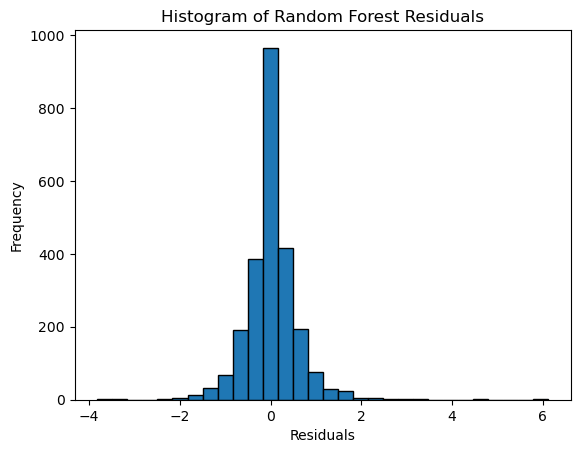

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Select relevant columns for DR-RF modeling
dr_rf_cols = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 
                 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 
                 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 
                 'Skill Moves', 'Value', 'Age', 'Overall','Wage']

# Create the feature matrix X and target variable y
X_dr_rf = df_DRRF[dr_rf_cols].dropna().drop('Overall', axis=1)
y_dr_rf = df_DRRF['Overall']
treat_dr_rf = df_DRRF['FinalTreatment']

# Split the data into training and testing sets
X_train_dr_rf, X_test_dr_rf, y_train_dr_rf, y_test_dr_rf, treat_train_dr_rf, treat_test_dr_rf = train_test_split(
    X_dr_rf, y_dr_rf, treat_dr_rf, test_size=0.2, random_state=1
)

# Fit logistic regression for treatment propensity
propensity_model_dr_rf = LogisticRegression()
propensity_model_dr_rf.fit(X_train_dr_rf, treat_train_dr_rf)

# Predict treatment probabilities on the test set
propensity_scores_dr_rf = propensity_model_dr_rf.predict_proba(X_test_dr_rf)[:, 1]

# Standardize numerical variables (optional but can be beneficial)
scaler_dr_rf = StandardScaler()
X_train_std_dr_rf = scaler_dr_rf.fit_transform(X_train_dr_rf)
X_test_std_dr_rf = scaler_dr_rf.transform(X_test_dr_rf)

# Fit outcome regression model (Random Forest)
outcome_model_dr_rf = RandomForestRegressor(n_estimators=100, random_state=1)
outcome_model_dr_rf.fit(X_train_std_dr_rf, y_train_dr_rf)

# Predict the potential outcomes under treatment and control
y_treated_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)
y_control_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)

# Calculate the doubly robust treatment effect estimate
dr_estimate_rf = np.mean(treat_test_dr_rf * (y_test_dr_rf - y_treated_dr_rf) / propensity_scores_dr_rf +
                         (1 - treat_test_dr_rf) * (y_treated_dr_rf - y_test_dr_rf) / (1 - propensity_scores_dr_rf))

# Print the Doubly Robust treatment effect estimate
#print(f"Doubly Robust Treatment Effect Estimate (Random Forest): {dr_estimate_rf}")

# Check for accuracy (optional)
treat_pred_dr_rf = propensity_scores_dr_rf > 0.5  # Adjust threshold as needed
accuracy_dr_rf = accuracy_score(treat_test_dr_rf, treat_pred_dr_rf)
#print(f"Accuracy of Propensity Model (Random Forest): {accuracy_dr_rf}")

# # Assuming df_DRRF is your DataFrame with the Doubly Robust Random Forest results
# df_DRRF['Wage'] = df_DRRF['Wage'].apply(pd.to_numeric, errors='coerce')

# # Create a new column indicating treatment status
# df_DRRF['Treated'] = (df_DRRF['Wage'] > df_DRRF['Wage'].median()).astype(int)

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated_rf = df_DRRF[df_DRRF['FinalTreatment'] == 1]['Overall'].mean()
mean_outcome_untreated_rf = df_DRRF[df_DRRF['FinalTreatment'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRRF = mean_outcome_treated_rf - mean_outcome_untreated_rf

#print('Average Treatment Effect on the Treated (ATT) for DR-RF:', ATT_DRRF)

# Evaluate model performance
y_pred_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)
rmse_dr_rf = np.sqrt(mean_squared_error(y_test_dr_rf, y_pred_dr_rf))
r2_dr_rf = r2_score(y_test_dr_rf, y_pred_dr_rf)

#print('RMSE:', rmse_dr_rf)
#print('R-squared:', r2_dr_rf)

# # Assuming df_DRRF is your DataFrame with the Doubly Robust Treatment Effect Estimate
# df_DRRF['Treated'] = (df_DRRF['Wage'] > df_DRRF['Wage'].median()).astype(int)

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated_rf = df_DRRF[df_DRRF['FinalTreatment'] == 1]['Overall'].mean()
mean_outcome_untreated_rf = df_DRRF[df_DRRF['FinalTreatment'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRRF = mean_outcome_treated_rf - mean_outcome_untreated_rf

#print('Average Treatment Effect on the Treated (ATT) for DR-RF:', ATT_DRRF)

# Calculate predicted probabilities from the Doubly Robust Random Forest model
propensity_scores_rf = propensity_model_dr_rf.predict_proba(X_test_dr_rf)[:, 1]

# Calculate F1 score
f1_rf = f1_score(treat_test_dr_rf, treat_pred_dr_rf)
#print(f"F1 Score: {f1_rf}")

# Calculate AUC-ROC
roc_auc_rf = roc_auc_score(treat_test_dr_rf, propensity_scores_rf)
# print(f"AUC-ROC Score: {roc_auc_rf}")

columns_of_interest = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 
             'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 
             'Agility', 'BallControl', 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 
             'HeadingAccuracy', 'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age','Wage']

# Create an empty dictionary to store results
standardized_biases = {}

# Loop through each column of interest
for column in columns_of_interest:
    # Calculate mean and standard deviation for treated and untreated groups
    mean_treated = df_DRRF[df_DRRF['FinalTreatment'] == 1][column].mean()
    mean_untreated = df_DRRF[df_DRRF['FinalTreatment'] == 0][column].mean()

    std_treated = df_DRRF[df_DRRF['FinalTreatment'] == 1][column].std()
    std_untreated = df_DRRF[df_DRRF['FinalTreatment'] == 0][column].std()

    # Calculate Standardized Bias for the current column
    standardized_bias = (mean_treated - mean_untreated) / np.sqrt((std_treated**2 + std_untreated**2) / 2)
    
    # Store the result in the dictionaryround(std_bias_age_rf, 5)
    standardized_biases[column] =round(standardized_bias, 5) 

from prettytable import PrettyTable

# Summary Report Data
summary_data_rf = [
    ["Doubly Robust Treatment Effect Estimate (Random Forest)", round(dr_estimate_rf, 5)],
    ["Accuracy of Propensity Model (Random Forest)", round(accuracy_dr_rf, 5)],
    ["ATT for DR-RF", round(ATT_DRRF, 5)],
    ["RMSE", round(rmse_dr_rf, 5)],
    ["R-squared", round(r2_dr_rf, 5)],
    ["F1 Score", round(f1_rf, 5)],
    ["AUC-ROC Score", round(roc_auc_rf, 5)],
]
# for variable, bias in standardized_biases.items():
#     summary_data_rf.append([f"Standardized Bias for {variable}", bias])

# Create the table
table_rf = PrettyTable()
table_rf.field_names = ["Metric", "Value"]

# Add data to the table
for row in summary_data_rf:
    table_rf.add_row(row)

# Set the alignment of the columns
table_rf.align["Metric"] = "l"
table_rf.align["Value"] = "r"

# Print the table
print(table_rf)




residuals = y_test_dr_rf - y_pred_dr_rf
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Random Forest Residuals')
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


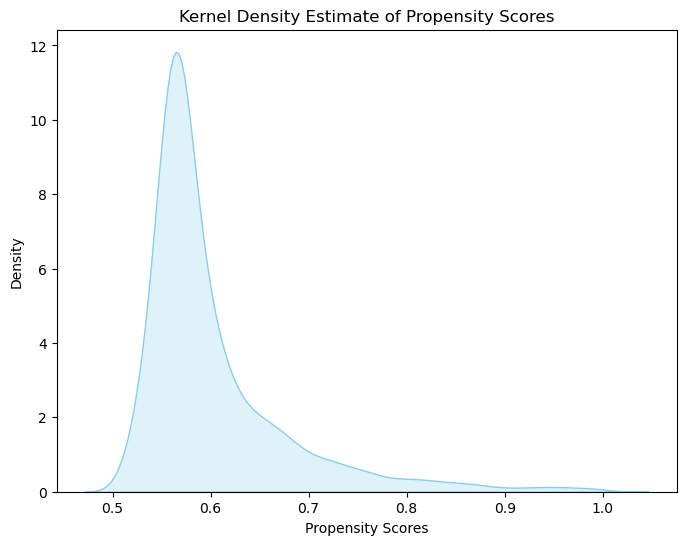

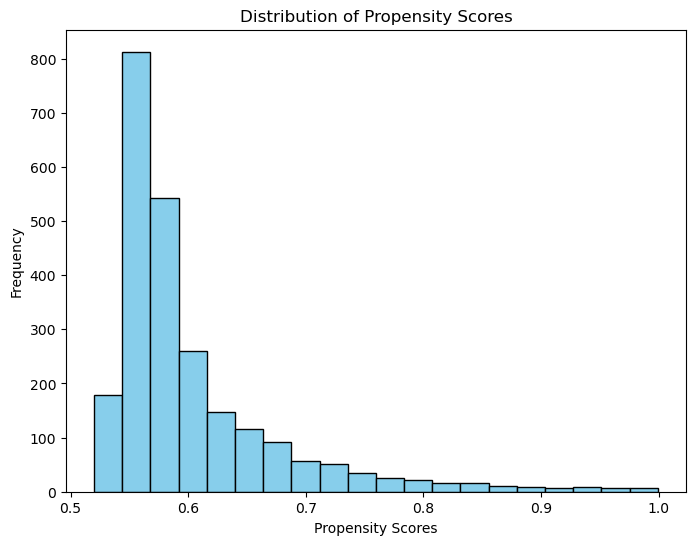

In [48]:
import seaborn as sns

# Plot kernel density estimate of propensity scores
plt.figure(figsize=(8, 6))
sns.kdeplot(propensity_scores_dr_rf, fill=True, color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Propensity Scores')
plt.show()

import matplotlib.pyplot as plt

# Plot histogram of propensity scores
plt.figure(figsize=(8, 6))
plt.hist(propensity_scores_dr_rf, bins=20, edgecolor='black', color='skyblue')
plt.xlabel('Propensity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.show()


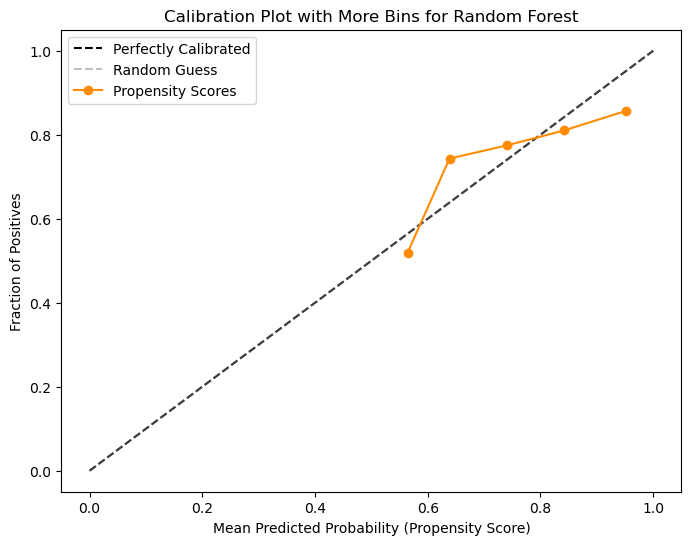

In [18]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true_rf, prob_pred_rf = calibration_curve(treat_test_dr_rf, propensity_scores_rf, n_bins=10, strategy='uniform')

# Plot the calibration curve treat_pred_dr_rf
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5, label='Random Guess')

# Plot the calibration curve with more bins
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Propensity Scores', color='darkorange')

plt.xlabel('Mean Predicted Probability (Propensity Score)')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot with More Bins for Random Forest')
plt.legend(loc='upper left')
plt.show()


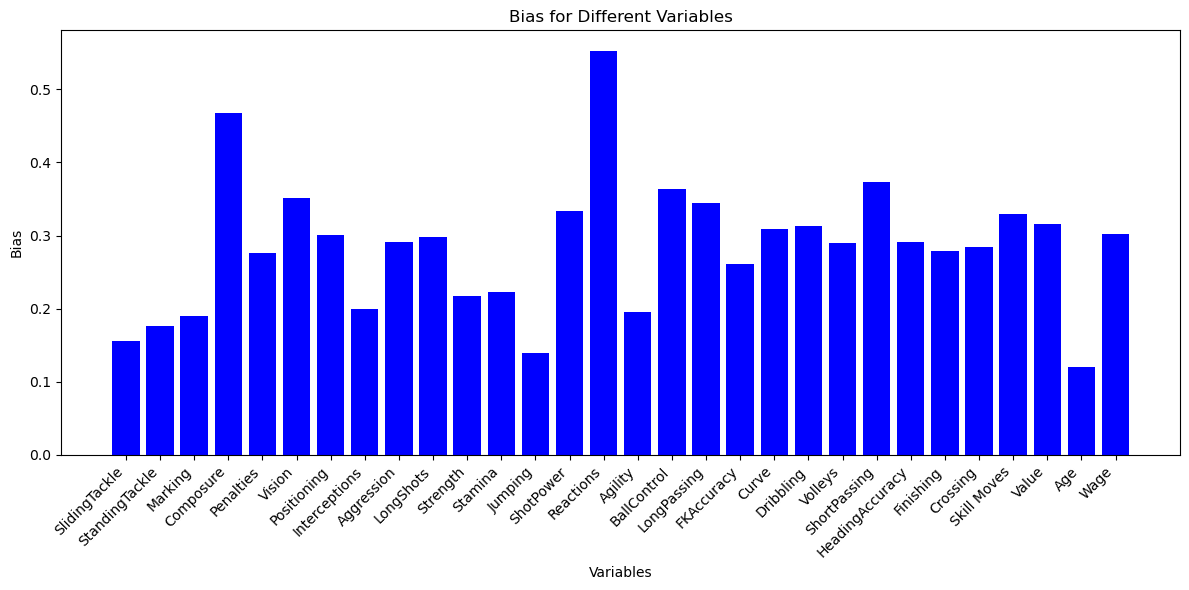

In [19]:
import matplotlib.pyplot as plt

# Extract variable names and biases
variables = list(standardized_biases.keys())
biases = list(standardized_biases.values())

# Create a bar plot with rotated x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(variables, biases, color='blue')
plt.xlabel('Variables')
plt.ylabel('Bias')
plt.title('Bias for Different Variables')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


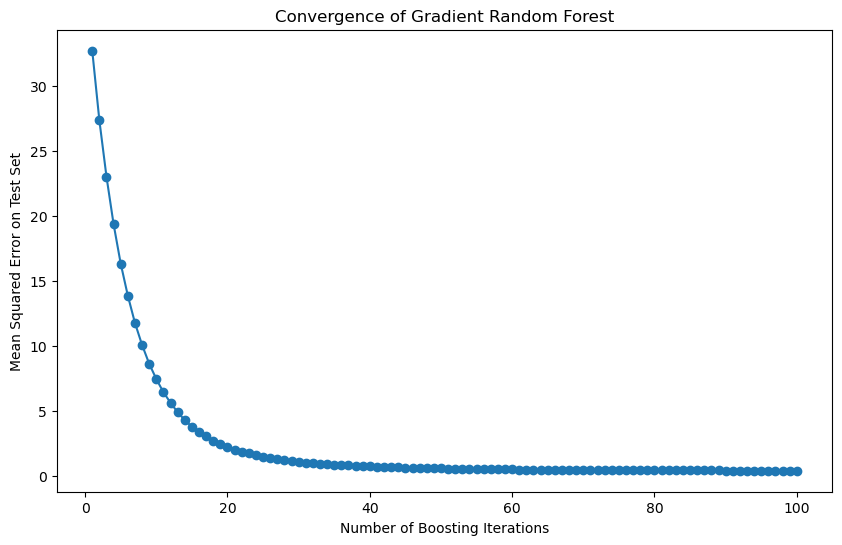

In [20]:
import matplotlib.pyplot as plt

# Fit outcome regression model (can be any model suitable for your data)
outcome_model_dr = GradientBoostingRegressor(n_estimators=100, random_state=1)
outcome_model_dr.fit(X_train_std_dr_rf, y_train_dr_rf)

# Access the staged predictions on the test set for each boosting iteration
staged_predictions = list(outcome_model_dr.staged_predict(X_test_std_dr_rf))

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(staged_predictions) + 1), [mean_squared_error(y_test_dr_rf, pred) for pred in staged_predictions], marker='o')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Mean Squared Error on Test Set')
plt.title('Convergence of Gradient Random Forest')
plt.show()


# Naive Bayes

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Naive comparison of outcomes between treated and untreated groups
treated_group = df_Naive[df_Naive['FinalTreatment'] == 1]['Overall']
untreated_group = df_Naive[df_Naive['FinalTreatment'] == 0]['Overall']

# Perform t-test for comparison
t_statistic, p_value = ttest_ind(treated_group, untreated_group, equal_var=False)

# Calculate average treatment effect (Naive)
att_naive = treated_group.mean() - untreated_group.mean()

# Calculate efficiency
efficiency = 1 / (1 + p_value)

# Create a dummy prediction (the mean of the treated group)
naive_prediction = np.full_like(df_Naive['Overall'], treated_group.mean())

# Calculate accuracy (assuming a binary classification problem, e.g., threshold at the median)
naive_accuracy = accuracy_score(df_Naive['FinalTreatment'], (df_Naive['Overall'] > df_Naive['Overall'].median()).astype(int))

# Calculate RMSE
naive_rmse = np.sqrt(mean_squared_error(df_Naive['Overall'], naive_prediction))

# Calculate R-squared
naive_r_squared = r2_score(df_Naive['Overall'], naive_prediction)


standardized_biases = {}

def calculate_standardized_bias(df_Naive, variable, treated_col, untreated_col):
    mean_treated = df_Naive[df_Naive[treated_col] == 1][variable].mean()
    mean_untreated = df_Naive[df_Naive[treated_col] == 0][variable].mean()
    std_treated = df_Naive[df_Naive[treated_col] == 1][variable].std()
    std_untreated = df_Naive[df_Naive[treated_col] == 0][variable].std()

    standardized_bias = (mean_treated - mean_untreated) / np.sqrt((std_treated**2 + std_untreated**2) / 2)

    return standardized_bias

# Your list of 30 columns
columns_list = ['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision',
                'Positioning', 'Interceptions', 'Aggression', 'LongShots', 'Strength', 'Stamina',
                'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 'LongPassing',
                'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy',
                'Finishing', 'Crossing', 'Skill Moves', 'Value', 'Age']

# Calculate and print standardized bias for each variable
for column in columns_list:
    standardized_bias = calculate_standardized_bias(df_Naive, column, 'FinalTreatment', 'Untreated')
    standardized_biases[column] = standardized_bias  # Update the dictionary

# Summary Report Data
summary_data_rf = [
    # ["T-Test Statistic", round(t_statistic, 5)],
    ["Average Treatment Effect (Naive)", round(att_naive, 5)],
    # ["Efficiency", round(efficiency, 5)],
    ["Accuracy", round(naive_accuracy, 5)],
    ["RMSE", round(naive_rmse, 5)],
    ["R-squared", round(naive_r_squared, 5)],
]
# for variable, bias in standardized_biases.items():
#     summary_data_rf.append([f"Standardized Bias for {variable}", bias])

# Create the table
table_rf = PrettyTable()
table_rf.field_names = ["Metric", "Value"]

# Add data to the table
for row in summary_data_rf:
    table_rf.add_row(row)

# Set the alignment of the columns
table_rf.align["Metric"] = "l"
table_rf.align["Value"] = "r"

# Print the table
print(table_rf)


+----------------------------------+----------+
| Metric                           |    Value |
+----------------------------------+----------+
| Average Treatment Effect (Naive) |  3.97966 |
| Accuracy                         |  0.61734 |
| RMSE                             |  6.35988 |
| R-squared                        | -0.05944 |
+----------------------------------+----------+


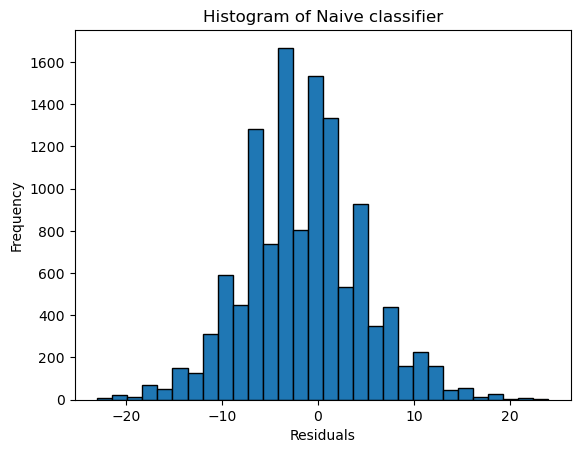

In [22]:
residuals = df_Naive['Overall'] - naive_prediction
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Naive classifier')
plt.show()



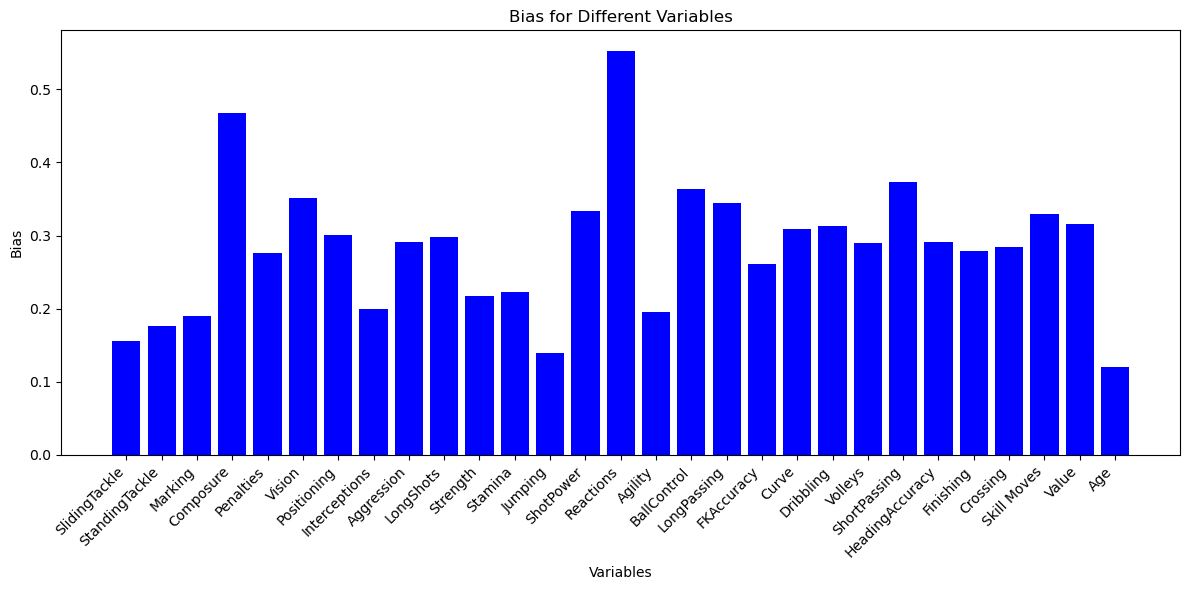

In [23]:
import matplotlib.pyplot as plt

# Extract variable names and biases
variables = list(standardized_biases.keys())
biases = list(standardized_biases.values())

# Create a bar plot with rotated x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(variables, biases, color='blue')
plt.xlabel('Variables')
plt.ylabel('Bias')
plt.title('Bias for Different Variables')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [25]:
# print(mean_value_untreated)

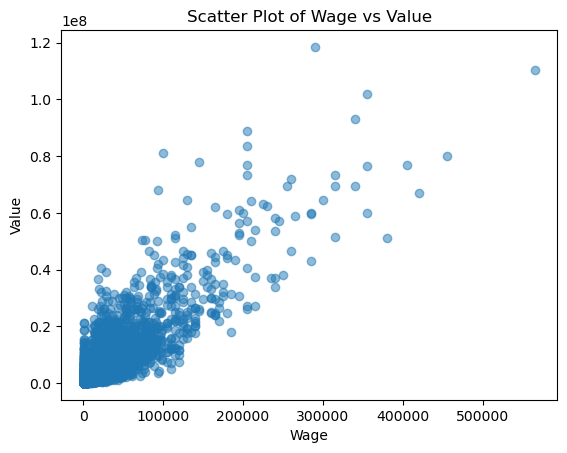

Correlation Coefficient between Wage and Value: 0.8550193082691586


In [26]:




import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Wage']
variable2 = df['Value']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Wage vs Value')
plt.xlabel('Wage')
plt.ylabel('Value')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Wage and Value: {correlation_coefficient}")


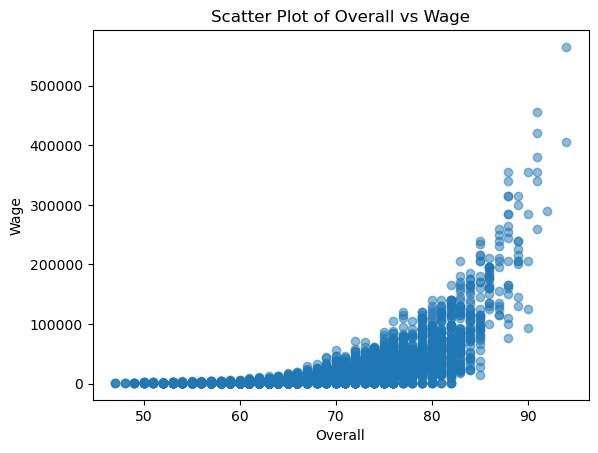

Correlation Coefficient between Overall and Wage: 0.6247963942663803


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Overall']
variable2 = df['Wage']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Overall vs Wage')
plt.xlabel('Overall')
plt.ylabel('Wage')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Overall and Wage: {correlation_coefficient}")


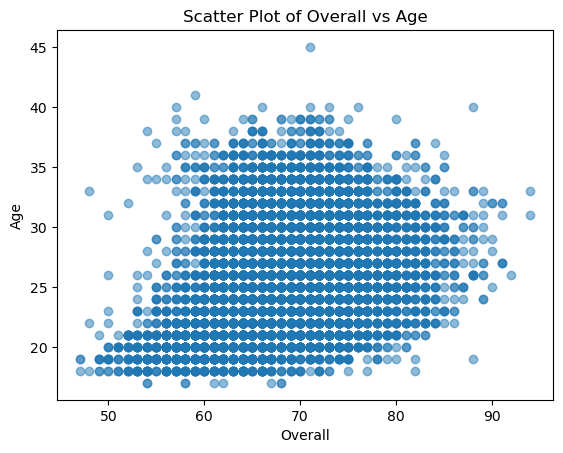

Correlation Coefficient between Overall and Age: 0.2956096959522062


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Overall']
variable2 = df['Age']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Overall vs Age')
plt.xlabel('Overall')
plt.ylabel('Age')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Overall and Age: {correlation_coefficient}")


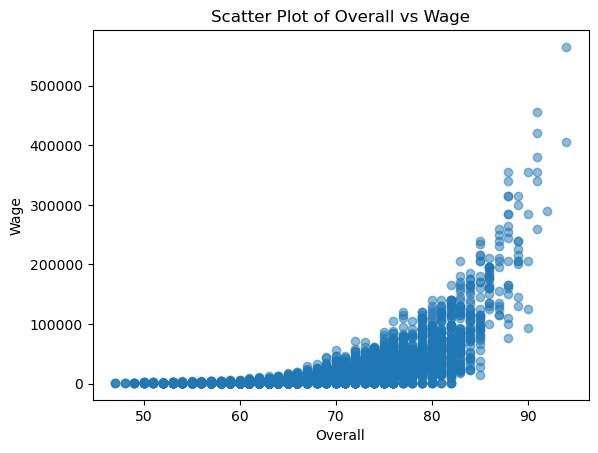

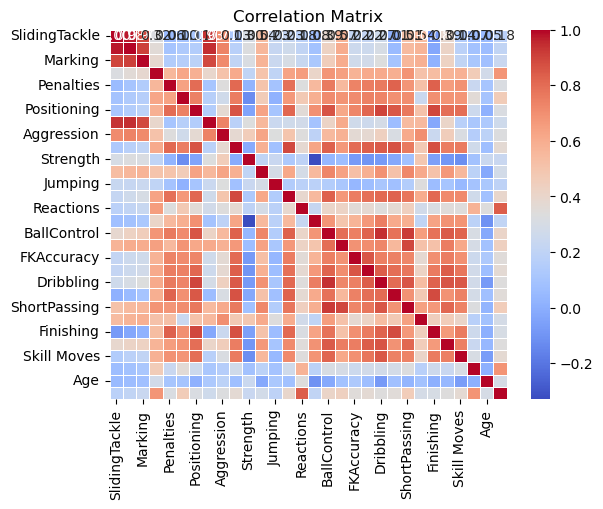

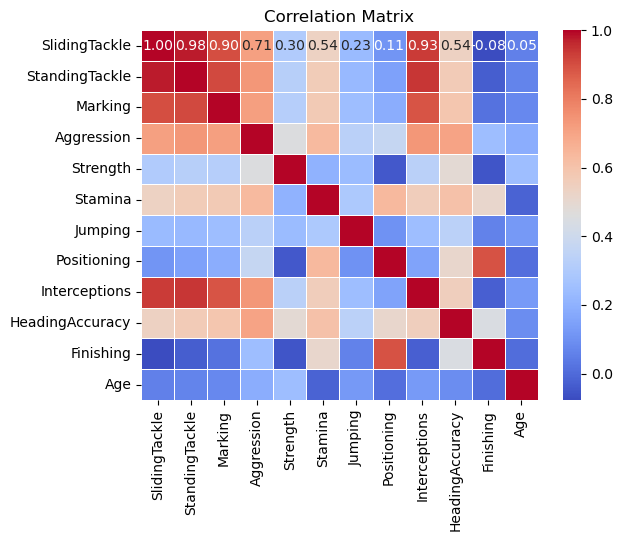

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Replace 'Overall' and 'Age' with the actual column names in your DataFrame
variable1 = df['Overall']
variable2 = df['Wage']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Overall vs Wage')
plt.xlabel('Overall')
plt.ylabel('Wage')
plt.show()




# Create a correlation matrix
correlation_matrix = df[['SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'Positioning', 'Interceptions', 
                 'Aggression', 'LongShots', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Reactions', 'Agility', 'BallControl', 
                 'LongPassing', 'FKAccuracy', 'Curve', 'Dribbling', 'Volleys', 'ShortPassing', 'HeadingAccuracy', 'Finishing', 'Crossing', 
                 'Skill Moves', 'Value', 'Age', 'Overall']].corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


# Create a correlation matrix
correlation_matrix = df[['SlidingTackle', 'StandingTackle', 'Marking', 'Aggression', 'Strength', 
                         'Stamina', 'Jumping', 'Positioning', 'Interceptions', 'HeadingAccuracy', 'Finishing', 'Age']].corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()



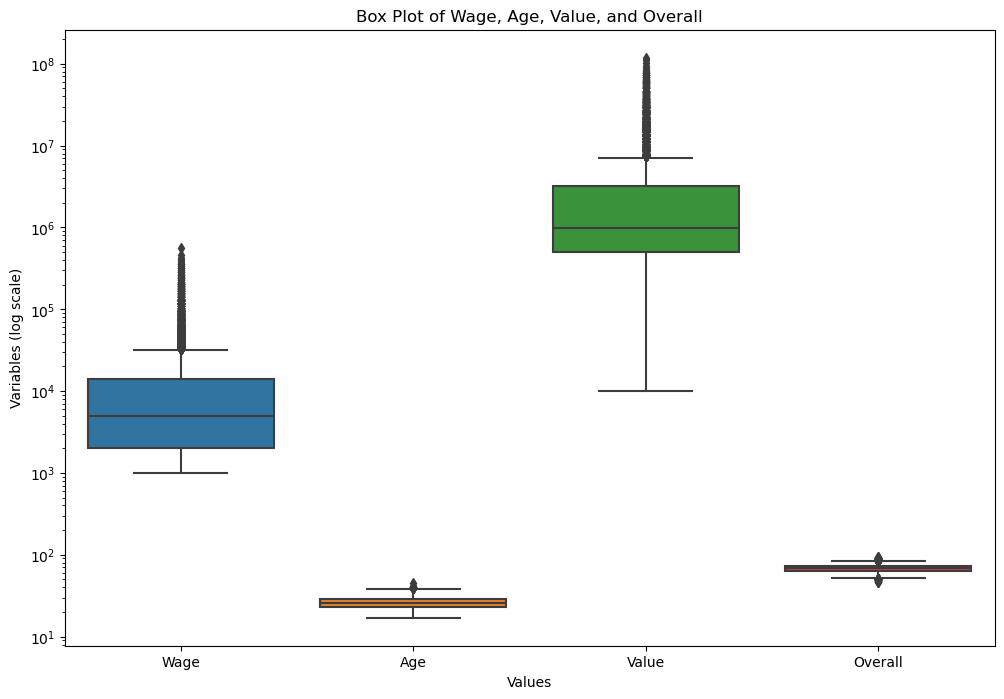

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Replace df with the actual variable name of your DataFrame

# Select the columns for the box plot
data = df[['Wage', 'Age', 'Value', 'Overall']]

# Create a box plot with a logarithmic y-axis scale
plt.figure(figsize=(12, 8))
sns.boxplot(data=data)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Box Plot of Wage, Age, Value, and Overall')
plt.xlabel('Values')
plt.ylabel('Variables (log scale)')
plt.show()

In [31]:
max_overall = y_treated_dr.max()
print(f"The maximum value of FR Linear Reg'Overall' is: {max_overall}")

max_overall = y_pred.max()
print(f"The maximum value of DR Logistic Reg'Overall' is: {max_overall}")


max_overall = y_treated_dr_rf.min()
print(f"The maximum value of DR RF'Overall' is: {max_overall}")


The maximum value of FR Linear Reg'Overall' is: 90.21497875438976
The maximum value of DR Logistic Reg'Overall' is: 104.65827019674013
The maximum value of DR RF'Overall' is: 48.72


In [32]:
median_outcome = np.median(y_treated_dr)
print(f"Median of the Outcome Variable: {median_outcome}")


Median of the Outcome Variable: 67.89646946742616


In [33]:
median_outcome = np.median(y_pred)
print(f"Median of the Outcome Variable: {median_outcome}")


Median of the Outcome Variable: 69.91000755055504


In [34]:
import numpy as np

# Assuming y_pred_xgb is your predicted values
predicted_values = np.array(y_pred)

# Count the number of values within the range 0-80
within_range_count = np.sum((predicted_values >= 0) & (predicted_values <= 80))

# Count the number of values more than 80
above_80_count = np.sum(predicted_values > 80)

print(f'Number of values within the range 0-80: {within_range_count}')
print(f'Number of values more than 80: {above_80_count}')


Number of values within the range 0-80: 2347
Number of values more than 80: 73
